In [15]:
from numpy import *
import numpy as np
import time
svd = linalg.svd
randn = random.randn
import numba
from numba import njit
from pylab import *
ion()
import scipy
from scipy import ndimage

In [16]:
## load in the test images

testmu = load("./data/UWDRO1_slice40_attenuation.npy")[::2,::2]*1.
testlambda = load("./data/UWDRO1_slice40_activity.npy")[::2,::2]*1.
mumask = testmu*0.
mumask[testmu>0.]=1.

In [17]:
## set up parameters of the system

small = 1.e-10 # small constant to avoid numerical error
totalcounts = 1.0e6 # sum over tof data

nx = 128 
ny = 128
ximageside = 30.0   #cm
yimageside = 30.0   #cm
dx = ximageside/nx
dy = yimageside/ny
xar=arange(-ximageside/2. + dx/2 , ximageside/2., dx)[:,newaxis]*ones([nx])
yar=ones([nx,ny])*arange(-yimageside/2. + dy/2 , yimageside/2., dy)
rar=sqrt(xar**2 + yar**2)
fovmask = testlambda*0.
smallmask = testlambda*0.
fovmask[rar<=ximageside/2.] = 1.
smallmask[sqrt((xar-0.)**2 + (yar-5.)**2)<=ximageside/20.] = 1.
#fovmask.fill(1.)
#the fovmask confines the image to the largest inscribed circle of the image array
mumask = fovmask*1.
#testlambda *= smallmask

radius = 100.0    #cm
detector1_to_detector2 = 200.0   #cm
nviews = 128
slen = pi     #angular range of the scan
nbins = 128
# The linear detector length is computed in the projection function so that it is
# the exact size needed to capture the projection of the largest inscribed circle in
# the image array.

dtc = dx/16.
ntc = int(detector1_to_detector2/dtc)
tcshift = 0.5*(detector1_to_detector2 - ntc*dtc)
war = arange(radius-detector1_to_detector2+tcshift,radius,dtc)

fwhm = 9.0 #cm
tofspacing = fwhm/2.
toflen = ximageside+2*fwhm
toflen = minimum(toflen,detector1_to_detector2)

print("TOF res. is: ",2.*fwhm/0.0299792458," picoseconds.")
tofsig= fwhm/2.355
dtof = tofspacing
ntof = int(toflen/dtof)
toflen = ntof*dtof    #change the toflen so that it is a multiple of dtof
print("toflen: ",toflen," ntof: ",ntof)
tof0 = -toflen/2.
tofmat = []
for i in range(ntof):
   w0 = (i+0.5)*dtof + tof0
   wfun = exp( -((war-w0)**2)/(2.*tofsig**2))
   tofmat.append(wfun)
tofmat = array(tofmat)

TOF res. is:  600.4153713566737  picoseconds.
toflen:  45.0  ntof:  10


In [18]:
## function for forward projection

@njit(cache=True) # If computing projection multiple times use: @njit(cache=True)
def circularParallelBeamProjection(wimage,sinogram, mask = mumask,
                              nx = nx, ny = ny, ximageside = ximageside, yimageside = yimageside,
                              radius = radius, detector1_to_detector2 = detector1_to_detector2,
                              nviews = nviews, slen = slen, nbins = nbins):

   sinogram.fill(0.)
   image = mask*wimage
   dx = ximageside/nx
   dy = yimageside/ny
   x0 = -ximageside/2.
   y0 = -yimageside/2.

   #compute length of detector so that it views the inscribed FOV of the image array
   detectorlength = ximageside   # This only works for ximageside = yimageside
   u0 = -detectorlength/2.

   du = detectorlength/nbins
   ds = slen/nviews

   for sindex in range(nviews):
#      print("Doing view number: ",sindex)   #UNCOMMENT if you want to see view progress
      s = sindex*ds
# detector1 center
      xDet1Center=radius*cos(s)
      yDet1Center=radius*sin(s)

# detector2 center
      xDet2Center=(radius - detector1_to_detector2)*cos(s)
      yDet2Center=(radius - detector1_to_detector2)*sin(s)

# unit vector in the direction of the detector line
      eux = -sin(s)
      euy =  cos(s)

# Unit vector in the direction perpendicular to the detector line
      ewx = cos(s)
      ewy = sin(s)

      for uindex in range(nbins):

         u = u0+(uindex+0.5)*du
         xbin1 = xDet1Center + eux*u
         ybin1 = yDet1Center + euy*u

         xbin2 = xDet2Center + eux*u
         ybin2 = yDet2Center + euy*u

         xl=x0
         yl=y0

         xdiff=xbin2-xbin1
         ydiff=ybin2-ybin1
         xad=abs(xdiff)*dy
         yad=abs(ydiff)*dx

         if (xad>yad):   # loop through x-layers of image if xad>yad. This ensures ray hits only one or two pixels per layer
            slope=ydiff/xdiff
            travPixlen=dx*sqrt(1.0+slope*slope)
            yIntOld=ybin1+slope*(xl-xbin1)
            iyOld=int(floor((yIntOld-y0)/dy))
            raysum=0.
            for ix in range(nx):
               x=xl+dx*(ix + 1.0)
               yIntercept=ybin1+slope*(x-xbin1)
               iy=int(floor((yIntercept-y0)/dy))
               if iy == iyOld: # if true, ray stays in the same pixel for this x-layer
                  if ((iy >= 0) and (iy < ny)):
                     raysum=raysum+travPixlen*image[ix,iy]
               else:    # else case is if ray hits two pixels for this x-layer
                  yMid=dy*max(iy,iyOld)+yl
                  ydist1=abs(yMid-yIntOld)
                  ydist2=abs(yIntercept-yMid)
                  frac1=ydist1/(ydist1+ydist2)
                  frac2=1.0-frac1
                  if ((iyOld >= 0) and (iyOld < ny)):
                     raysum = raysum+frac1*travPixlen*image[ix,iyOld]
                  if ((iy>=0) and (iy<ny)):
                     raysum=raysum+frac2*travPixlen*image[ix,iy]
               iyOld=iy
               yIntOld=yIntercept
         else: # loop through y-layers of image if xad<=yad
            slopeinv=xdiff/ydiff
            travPixlen=dy*sqrt(1.0+slopeinv*slopeinv)
            xIntOld=xbin1+slopeinv*(yl-ybin1)
            ixOld=int(floor((xIntOld-x0)/dx))
            raysum=0.
            for iy in range(ny):
               y=yl+dy*(iy + 1.0)
               xIntercept=xbin1+slopeinv*(y-ybin1)
               ix=int(floor((xIntercept-x0)/dx))
               if (ix == ixOld): # if true, ray stays in the same pixel for this y-layer
                  if ((ix >= 0) and (ix < nx)):
                     raysum=raysum+travPixlen*image[ix,iy]
               else:  # else case is if ray hits two pixels for this y-layer
                  xMid=dx*max(ix,ixOld)+xl
                  xdist1=abs(xMid-xIntOld)
                  xdist2=abs(xIntercept-xMid)
                  frac1=xdist1/(xdist1+xdist2)
                  frac2=1.0-frac1
                  if ((ixOld >= 0) and (ixOld < nx)) :
                     raysum=raysum+frac1*travPixlen*image[ixOld,iy]
                  if ((ix>=0) and (ix<nx)) :
                     raysum=raysum+frac2*travPixlen*image[ix,iy]
               ixOld=ix
               xIntOld=xIntercept
         sinogram[sindex,uindex]=raysum



In [19]:
## function for backward projection
@njit(cache=True) # If computing projection multiple times use: @njit(cache=True)
def circularParallelBeamBackProjection(sinogram, image, mask = mumask,
                              nx = nx, ny = ny, ximageside = ximageside, yimageside = yimageside,
                              radius = radius, detector1_to_detector2 = detector1_to_detector2,
                              nviews = nviews, slen = slen, nbins = nbins):

   image.fill(0.)

   dx = ximageside/nx
   dy = yimageside/ny
   x0 = -ximageside/2.
   y0 = -yimageside/2.

   #compute length of detector so that it views the inscribed FOV of the image array
   detectorlength = ximageside   # This only works for ximageside = yimageside
   u0 = -detectorlength/2.

   du = detectorlength/nbins
   ds = slen/nviews

   for sindex in range(nviews):
#      print("Doing view number: ",sindex)   #UNCOMMENT if you want to see view progress
      s = sindex*ds
# detector1 center
      xDet1Center=radius*cos(s)
      yDet1Center=radius*sin(s)

# detector2 center
      xDet2Center=(radius - detector1_to_detector2)*cos(s)
      yDet2Center=(radius - detector1_to_detector2)*sin(s)

# unit vector in the direction of the detector line
      eux = -sin(s)
      euy =  cos(s)

# Unit vector in the direction perpendicular to the detector line
      ewx = cos(s)
      ewy = sin(s)

      for uindex in range(nbins):
         sinoval = sinogram[sindex,uindex]

         u = u0+(uindex+0.5)*du
         xbin1 = xDet1Center + eux*u
         ybin1 = yDet1Center + euy*u

         xbin2 = xDet2Center + eux*u
         ybin2 = yDet2Center + euy*u

         xl=x0
         yl=y0

         xdiff=xbin2-xbin1
         ydiff=ybin2-ybin1
         xad=abs(xdiff)*dy
         yad=abs(ydiff)*dx

         if (xad>yad):   # loop through x-layers of image if xad>yad. This ensures ray hits only one or two pixels per layer
            slope=ydiff/xdiff
            travPixlen=dx*sqrt(1.0+slope*slope)
            yIntOld=ybin1+slope*(xl-xbin1)
            iyOld=int(floor((yIntOld-y0)/dy))
            for ix in range(nx):
               x=xl+dx*(ix + 1.0)
               yIntercept=ybin1+slope*(x-xbin1)
               iy=int(floor((yIntercept-y0)/dy))
               if iy == iyOld: # if true, ray stays in the same pixel for this x-layer
                  if ((iy >= 0) and (iy < ny)):
                     image[ix,iy] =image[ix,iy]+sinoval*travPixlen
               else:    # else case is if ray hits two pixels for this x-layer
                  yMid=dy*max(iy,iyOld)+yl
                  ydist1=abs(yMid-yIntOld)
                  ydist2=abs(yIntercept-yMid)
                  frac1=ydist1/(ydist1+ydist2)
                  frac2=1.0-frac1
                  if ((iyOld >= 0) and (iyOld < ny)):
                     image[ix,iyOld] =image[ix,iyOld]+frac1*sinoval*travPixlen
                  if ((iy>=0) and (iy<ny)):
                     image[ix,iy] =image[ix,iy]+frac2*sinoval*travPixlen
               iyOld=iy
               yIntOld=yIntercept
         else: # loop through y-layers of image if xad<=yad
            slopeinv=xdiff/ydiff
            travPixlen=dy*sqrt(1.0+slopeinv*slopeinv)
            xIntOld=xbin1+slopeinv*(yl-ybin1)
            ixOld=int(floor((xIntOld-x0)/dx))
            for iy in range(ny):
               y=yl+dy*(iy + 1.0)
               xIntercept=xbin1+slopeinv*(y-ybin1)
               ix=int(floor((xIntercept-x0)/dx))
               if (ix == ixOld): # if true, ray stays in the same pixel for this y-layer
                  if ((ix >= 0) and (ix < nx)):
                     image[ix,iy] =image[ix,iy]+sinoval*travPixlen
               else:  # else case is if ray hits two pixels for this y-layer
                  xMid=dx*max(ix,ixOld)+xl
                  xdist1=abs(xMid-xIntOld)
                  xdist2=abs(xIntercept-xMid)
                  frac1=xdist1/(xdist1+xdist2)
                  frac2=1.0-frac1
                  if ((ixOld >= 0) and (ixOld < nx)) :
                     image[ixOld,iy] =image[ixOld,iy]+frac1*sinoval*travPixlen
                  if ((ix>=0) and (ix<nx)) :
                     image[ix,iy] =image[ix,iy]+frac2*sinoval*travPixlen
               ixOld=ix
               xIntOld=xIntercept
   image *= mask




In [20]:
## function for weighted forward projection
@njit(cache=True) # if computing projection multiple times use: @njit(cache=true)
def circularParallelBeamWProjection(image,sinogram, weighting, dtc = dtc, tcshift = tcshift,
                              nx = nx, ny = ny, ximageside = ximageside, yimageside = yimageside,
                              radius = radius, detector1_to_detector2 = detector1_to_detector2,
                              nviews = nviews, slen = slen, nbins = nbins):

   sinogram.fill(0.)
   
   dx = ximageside/nx
   dy = yimageside/ny
   x0 = -ximageside/2.
   y0 = -yimageside/2.


   #compute length of detector so that it views the inscribed FOV of the image array
   detectorlength = ximageside   # This only works for ximageside = yimageside
   u0 = -detectorlength/2.

   du = detectorlength/nbins
   ds = slen/nviews

   for sindex in range(nviews):
#      print("Doing view number: ",sindex)   #UNCOMMENT if you want to see view progress
      s = sindex*ds
# detector1 center
      xDet1Center=radius*cos(s)
      yDet1Center=radius*sin(s)

# detector2 center
      xDet2Center=(radius - detector1_to_detector2)*cos(s)
      yDet2Center=(radius - detector1_to_detector2)*sin(s)

# unit vector in the direction of the detector line
      eux = -sin(s)
      euy =  cos(s)

# Unit vector in the direction perpendicular to the detector line
      ewx = cos(s)
      ewy = sin(s)

      for uindex in range(nbins):

         u = u0+(uindex+0.5)*du
         xbin1 = xDet1Center + eux*u
         ybin1 = yDet1Center + euy*u

         xbin2 = xDet2Center + eux*u
         ybin2 = yDet2Center + euy*u

         xl=x0
         yl=y0

         xdiff=xbin2-xbin1
         ydiff=ybin2-ybin1
         xad=abs(xdiff)*dy
         yad=abs(ydiff)*dx

         if (xad>yad):   # loop through x-layers of image if xad>yad. This ensues ray hits only one or two pixels per layer
            slope=ydiff/xdiff
            travPixlen=dx*sqrt(1.0+slope*slope)
            yIntOld=ybin1+slope*(xl-xbin1)
            iyOld=int(floor((yIntOld-y0)/dy))
            raysum=0.
            for ix in range(nx):
               x=xl+dx*(ix + 1.0)
               yIntercept=ybin1+slope*(x-xbin1)
               iy=int(floor((yIntercept-y0)/dy))

               xmid = xl+dx*(ix + 0.5)
               ymid = yl+dy*(iy + 0.5)
               tc = sqrt( (xmid-xbin1)**2 + (ymid-ybin1)**2 ) -tcshift
               tofweight1 = weighting[int(tc/dtc)]
               ymid = yl+dy*(iyOld + 0.5)
               tc = sqrt( (xmid-xbin1)**2 + (ymid-ybin1)**2 ) -tcshift
               tofweight2 = weighting[int(tc/dtc)]
               
               if iy == iyOld: # if true, ray stays in the same pixel for this x-layer
                  if ((iy >= 0) and (iy < ny)):
                     raysum=raysum+tofweight1*travPixlen*image[ix,iy]
               else:    # else case is if ray hits two pixels for this x-layer
                  yMid=dy*max(iy,iyOld)+yl
                  ydist1=abs(yMid-yIntOld)
                  ydist2=abs(yIntercept-yMid)
                  frac1=ydist1/(ydist1+ydist2)
                  frac2=1.0-frac1
                  if ((iyOld >= 0) and (iyOld < ny)):
                     raysum = raysum+tofweight2*frac1*travPixlen*image[ix,iyOld]
                  if ((iy>=0) and (iy<ny)):
                     raysum=raysum+tofweight1*frac2*travPixlen*image[ix,iy]
               iyOld=iy
               yIntOld=yIntercept
         else: # loop through y-layers of image if xad<=yad
            slopeinv=xdiff/ydiff
            travPixlen=dy*sqrt(1.0+slopeinv*slopeinv)
            xIntOld=xbin1+slopeinv*(yl-ybin1)
            ixOld=int(floor((xIntOld-x0)/dx))
            raysum=0.
            for iy in range(ny):
               y=yl+dy*(iy + 1.0)
               xIntercept=xbin1+slopeinv*(y-ybin1)
               ix=int(floor((xIntercept-x0)/dx))

               xmid = xl+dx*(ix + 0.5)
               ymid = yl+dy*(iy + 0.5)
               tc = sqrt( (xmid-xbin1)**2 + (ymid-ybin1)**2 ) -tcshift
               tofweight1 = weighting[int(tc/dtc)]
               xmid = xl+dx*(ixOld + 0.5)
               tc = sqrt( (xmid-xbin1)**2 + (ymid-ybin1)**2 ) -tcshift
               tofweight2 = weighting[int(tc/dtc)]
               
               if (ix == ixOld): # if true, ray stays in the same pixel for this y-layer
                  if ((ix >= 0) and (ix < nx)):
                     raysum=raysum+tofweight1*travPixlen*image[ix,iy]
               else:  # else case is if ray hits two pixels for this y-layer
                  xMid=dx*max(ix,ixOld)+xl
                  xdist1=abs(xMid-xIntOld)
                  xdist2=abs(xIntercept-xMid)
                  frac1=xdist1/(xdist1+xdist2)
                  frac2=1.0-frac1
                  if ((ixOld >= 0) and (ixOld < nx)) :
                     raysum=raysum+tofweight2*frac1*travPixlen*image[ixOld,iy]
                  if ((ix>=0) and (ix<nx)) :
                     raysum=raysum+tofweight1*frac2*travPixlen*image[ix,iy]
               ixOld=ix
               xIntOld=xIntercept
         sinogram[sindex,uindex]=raysum



In [21]:
## function for weighted backward projection

@njit(cache=True) # If computing projection multiple times use: @njit(cache=True)
def circularParallelBeamWBackProjection(sinogram, image, weighting, dtc = dtc, tcshift = tcshift,
                              nx = nx, ny = ny, ximageside = ximageside, yimageside = yimageside,
                              radius = radius, detector1_to_detector2 = detector1_to_detector2,
                              nviews = nviews, slen = slen, nbins = nbins):

   image.fill(0.)

   dx = ximageside/nx
   dy = yimageside/ny
   x0 = -ximageside/2.
   y0 = -yimageside/2.

   #compute length of detector so that it views the inscribed FOV of the image array
   detectorlength = ximageside   # This only works for ximageside = yimageside
   u0 = -detectorlength/2.

   du = detectorlength/nbins
   ds = slen/nviews

   for sindex in range(nviews):
#      print("Doing view number: ",sindex)   #UNCOMMENT if you want to see view progress
      s = sindex*ds
# detector1 center
      xDet1Center=radius*cos(s)
      yDet1Center=radius*sin(s)

# detector2 center
      xDet2Center=(radius - detector1_to_detector2)*cos(s)
      yDet2Center=(radius - detector1_to_detector2)*sin(s)

# unit vector in the direction of the detector line
      eux = -sin(s)
      euy =  cos(s)

# Unit vector in the direction perpendicular to the detector line
      ewx = cos(s)
      ewy = sin(s)

      for uindex in range(nbins):
         sinoval = sinogram[sindex,uindex]

         u = u0+(uindex+0.5)*du
         xbin1 = xDet1Center + eux*u
         ybin1 = yDet1Center + euy*u

         xbin2 = xDet2Center + eux*u
         ybin2 = yDet2Center + euy*u

         xl=x0
         yl=y0

         xdiff=xbin2-xbin1
         ydiff=ybin2-ybin1
         xad=abs(xdiff)*dy
         yad=abs(ydiff)*dx

         if (xad>yad):   # loop through x-layers of image if xad>yad. This ensures ray hits only one or two pixels per layer
            slope=ydiff/xdiff
            travPixlen=dx*sqrt(1.0+slope*slope)
            yIntOld=ybin1+slope*(xl-xbin1)
            iyOld=int(floor((yIntOld-y0)/dy))
            for ix in range(nx):
               x=xl+dx*(ix + 1.0)
               yIntercept=ybin1+slope*(x-xbin1)
               iy=int(floor((yIntercept-y0)/dy))

               xmid = xl+dx*(ix + 0.5)
               ymid = yl+dy*(iy + 0.5)
               tc = sqrt( (xmid-xbin1)**2 + (ymid-ybin1)**2 ) -tcshift
               tofweight1 = weighting[int(tc/dtc)]
               ymid = yl+dy*(iyOld + 0.5)
               tc = sqrt( (xmid-xbin1)**2 + (ymid-ybin1)**2 ) -tcshift
               tofweight2 = weighting[int(tc/dtc)]
               
               if iy == iyOld: # if true, ray stays in the same pixel for this x-layer
                  if ((iy >= 0) and (iy < ny)):
                     image[ix,iy] =image[ix,iy]+sinoval*travPixlen*tofweight1
               else:    # else case is if ray hits two pixels for this x-layer
                  yMid=dy*max(iy,iyOld)+yl
                  ydist1=abs(yMid-yIntOld)
                  ydist2=abs(yIntercept-yMid)
                  frac1=ydist1/(ydist1+ydist2)
                  frac2=1.0-frac1
                  if ((iyOld >= 0) and (iyOld < ny)):
                     image[ix,iyOld] =image[ix,iyOld]+frac1*sinoval*travPixlen*tofweight2
                  if ((iy>=0) and (iy<ny)):
                     image[ix,iy] =image[ix,iy]+frac2*sinoval*travPixlen*tofweight1
               iyOld=iy
               yIntOld=yIntercept
         else: # loop through y-layers of image if xad<=yad
            slopeinv=xdiff/ydiff
            travPixlen=dy*sqrt(1.0+slopeinv*slopeinv)
            xIntOld=xbin1+slopeinv*(yl-ybin1)
            ixOld=int(floor((xIntOld-x0)/dx))
            for iy in range(ny):
               y=yl+dy*(iy + 1.0)
               xIntercept=xbin1+slopeinv*(y-ybin1)
               ix=int(floor((xIntercept-x0)/dx))

               xmid = xl+dx*(ix + 0.5)
               ymid = yl+dy*(iy + 0.5)
               tc = sqrt( (xmid-xbin1)**2 + (ymid-ybin1)**2 ) -tcshift
               tofweight1 = weighting[int(tc/dtc)]
               xmid = xl+dx*(ixOld + 0.5)
               tc = sqrt( (xmid-xbin1)**2 + (ymid-ybin1)**2 ) -tcshift
               tofweight2 = weighting[int(tc/dtc)]
               
               if (ix == ixOld): # if true, ray stays in the same pixel for this y-layer
                  if ((ix >= 0) and (ix < nx)):
                     image[ix,iy] =image[ix,iy]+sinoval*travPixlen*tofweight1
               else:  # else case is if ray hits two pixels for this y-layer
                  xMid=dx*max(ix,ixOld)+xl
                  xdist1=abs(xMid-xIntOld)
                  xdist2=abs(xIntercept-xMid)
                  frac1=xdist1/(xdist1+xdist2)
                  frac2=1.0-frac1
                  if ((ixOld >= 0) and (ixOld < nx)) :
                     image[ixOld,iy] =image[ixOld,iy]+frac1*sinoval*travPixlen*tofweight2
                  if ((ix>=0) and (ix<nx)) :
                     image[ix,iy] =image[ix,iy]+frac2*sinoval*travPixlen*tofweight1
               ixOld=ix
               xIntOld=xIntercept



In [22]:
## functions for time-of-flight projection matrix multiplication

def TOFprojection(wimage,tofsino,mask=fovmask,tofmat=tofmat,ntof=ntof,nviews=nviews,nbins=nbins):
   tofsino.fill(0.)
   image = mask*wimage
   for i in range(ntof):
      circularParallelBeamWProjection(image,tofsino[i],tofmat[i])


def TOFbackProjection(tofsino,image,mask=fovmask,tofmat=tofmat,ntof=ntof,nviews=nviews,nbins=nbins):
   image.fill(0.)
   wim = image*0.
   for i in range(ntof):
      circularParallelBeamWBackProjection(tofsino[i],wim,tofmat[i])
      image += wim
   image *= mask

In [23]:
## nuclear norms of the projection matrices

# These values are hard-coded; code for computing 
# these values can be found in *****.py

ltofproj = 23.1500763
lproj =27.89508541
numu= 9.92287722
nulam= 8.23497622
ltotmu = 27.973308258
ltotlam = 23.24406084

In [24]:
## generate the emission data

sinogram=zeros([nviews,nbins],"float64")   
sinoatt = sinogram.copy()
sinoatt.fill(0.)
circularParallelBeamProjection(testmu,sinoatt)
attfactor = exp(-sinoatt)

tofsino = zeros([ntof,nviews,nbins])
TOFprojection(testlambda,tofsino)

truess = tofsino.sum(axis=0)
tofdata = attfactor*tofsino
datafactor = totalcounts/tofdata.sum() #scale the data to the desired count level

tofdata *= datafactor
tofsino *= datafactor
testlambda  *= datafactor
truess *= datafactor
tofdata0 = tofdata*1.0

tofdata = np.random.poisson(tofdata0).astype("float64") # draw the emission data from a poisson distribution

In [25]:
np.max(testlambda)

63.09641097697465

In [26]:
## utility functions for saatv-admm

#gradient implementations for TV
def gradim(image):

   xgrad = image.copy()
   ygrad = image.copy()
   temp = image
   xgrad[:-1,:] = temp[1:,:] - temp[:-1,:]
   ygrad[:,:-1] = temp[:,1:] - temp[:,:-1]
   xgrad[-1,:] =  -1.0* temp[-1,:]
   ygrad[:,-1] =  -1.0* temp[:,-1]

   return xgrad,ygrad


def mdiv(xgrad,ygrad):
   divim = xgrad.copy()
   shp = [xgrad.shape[0] + 2, xgrad.shape[1] +2]
   xgradp=zeros(shp)
   ygradp=zeros(shp)
   xgradp[1:-1,1:-1] = xgrad*1.
   ygradp[1:-1,1:-1] = ygrad*1.
   divim.fill(0.)
   divim = xgradp[:-2,1:-1] + ygradp[1:-1,:-2] - xgradp[1:-1,1:-1] - ygradp[1:-1,1:-1]

   return divim


def euclidean_proj_simplex(v, s=1):
   """ Compute the Euclidean projection on a positive simplex

    Solves the optimisation problem (using the algorithm from [1]):

        min_w 0.5 * || w - v ||_2^2 , s.t. \sum_i w_i = s, w_i >= 0 

    Parameters
    ----------
    v: (n,) numpy array,
       n-dimensional vector to project

    s: int, optional, default: 1,
       radius of the simplex

    Returns
    -------
    w: (n,) numpy array,
       Euclidean projection of v on the simplex

    Notes
    -----
    The complexity of this algorithm is in O(n log(n)) as it involves sorting v.
    Better alternatives exist for high-dimensional sparse vectors (cf. [1])
    However, this implementation still easily scales to millions of dimensions.

    References
    ----------
    [1] Efficient Projections onto the .1-Ball for Learning in High Dimensions
        John Duchi, Shai Shalev-Shwartz, Yoram Singer, and Tushar Chandra.
        International Conference on Machine Learning (ICML 2008)
        http://www.cs.berkeley.edu/~jduchi/projects/DuchiSiShCh08.pdf
    """
   assert s > 0, "Radius s must be strictly positive (%d <= 0)" % s
   n, = v.shape  # will raise ValueError if v is not 1-D
   # check if we are already on the simplex
   if v.sum() == s and np.alltrue(v >= 0):
      # best projection: itself!
      return v
   # get the array of cumulative sums of a sorted (decreasing) copy of v
   u = np.sort(v)[::-1]
   cssv = np.cumsum(u)
   # get the number of > 0 components of the optimal solution
   rho = np.nonzero(u * np.arange(1, n+1) > (cssv - s))[0][-1]
   # compute the Lagrange multiplier associated to the simplex constraint
   theta = (cssv[rho] - s) / (rho + 1.0)
   # compute the projection by thresholding v using theta
   w = (v - theta).clip(min=0)
   return w


def euclidean_proj_l1ball(v, s=1):
   """ Compute the Euclidean projection on a L1-ball

    Solves the optimisation problem (using the algorithm from [1]):

        min_w 0.5 * || w - v ||_2^2 , s.t. || w ||_1 <= s
   Parameters
    ----------
    v: (n,) numpy array,
       n-dimensional vector to project

    s: int, optional, default: 1,
       radius of the L1-ball

    Returns
    -------
    w: (n,) numpy array,
       Euclidean projection of v on the L1-ball of radius s

    Notes
    -----
    Solves the problem by a reduction to the positive simplex case

    See also
    --------
    euclidean_proj_simplex
    """
   assert s > 0, "Radius s must be strictly positive (%d <= 0)" % s
   n, = v.shape  # will raise ValueError if v is not 1-D
   # compute the vector of absolute values
   u = np.abs(v)
   # check if v is already a solution
   if u.sum() <= s:
       # L1-norm is <= s
       return v
   # v is not already a solution: optimum lies on the boundary (norm == s)
   # project *u* on the simplex
   w = euclidean_proj_simplex(u, s=s)
   # compute the solution to the original problem on v
   w *= np.sign(v)
   return w


In [27]:
## compute the ground truth constraints

ptvmu = 100
tgx,tgy = gradim(testmu)
tvmu = numu*sqrt(tgx**2 + tgy**2).sum() *(1.*ptvmu/100.0)

ptvlam = 100
tgx,tgy = gradim(testlambda)
tvlambda = nulam*sqrt(tgx**2 + tgy**2).sum() *(1.*ptvlam/100.0)
ltotalcounts = testlambda.sum()
print("the ground-truth TV constraint for the activity map: ",tvlambda)
print("the ground-truth TV constraint for the attenuation map: ",tvmu)
print("the ground-truth total count constraint for the activity map: ",ltotalcounts)

the ground-truth TV constraint for the activity map:  91316.61969103648
the ground-truth TV constraint for the attenuation map:  319.5319780852521
the ground-truth total count constraint for the activity map:  56559.56349102085


In [28]:
## number of iterations

niter = 101 # number of outer loops
newtiter = 10 # number of newton steps
nuv = 100 # number of alternating optimization steps


In [86]:
## TV-constrained saa-admm applied to noisy count data

# output directory
resultsfile = './results/saa_noisy_bothTV_'

# parameters 
tvlamswitch = 1
tvmuswitch = 1
sbmu = 50
sblambda = 0.01
sigmu = sbmu/lproj
taumu = 1.0/(sbmu*lproj)
siglambda = sblambda/ltofproj
taulambda = 1.0/(sblambda*ltofproj)

# initialization
worktofsino = 0.*tofsino
ulambda = 0.*tofsino
ylambda = 0.*tofsino

imlambda = testlambda*0.
wimlambda = testlambda*0.
ugradlamx = testlambda*0.
ygradlamx = testlambda*0.
ugradlamy = testlambda*0.
ygradlamy = testlambda*0.

worksino = 0.*sinoatt
umu = 0.*sinoatt
ymu = 0.*sinoatt
ugradmux = testlambda*0.
ygradmux = testlambda*0.
ugradmuy = testlambda*0.
ygradmuy = testlambda*0.

immu = testmu*0.
wimmu = testmu*0.

datarmses = []
imagelrmses = []
imagemrmses = []
attrmses = []
storeiterations=[1,2,5,10,20,50,100,200,500,1000]

# run saa-admm
for j in range(niter):
# x-update
   TOFprojection(imlambda,worktofsino)
   arg1 = ulambda+siglambda*(worktofsino -ylambda)
   TOFbackProjection(arg1,wimlambda)
   tgx,tgy = gradim(imlambda)
   tgx *= nulam
   tgy *= nulam

   argx = ugradlamx + siglambda*(tgx - ygradlamx)
   argy = ugradlamy + siglambda*(tgy - ygradlamy)
   wgradimlam = mdiv(argx,argy)
   wgradimlam *= nulam*fovmask
   tvlamest  = sqrt(tgx**2 + tgy**2).sum()

   nu  = ((imlambda.sum() -ltotalcounts)/taulambda - wimlambda.sum() - wgradimlam)/fovmask.sum()

   imlambda =imlambda -taulambda*(nu*fovmask + wimlambda + wgradimlam)
   TOFprojection(imlambda,worktofsino)
   workgradlamx, workgradlamy = gradim(imlambda)
   workgradlamx *= nulam
   workgradlamy *= nulam


   circularParallelBeamProjection(immu,worksino)
   arg1 = umu +sigmu*( worksino -ymu )
   circularParallelBeamBackProjection(arg1,wimmu)
   tgx,tgy = gradim(immu)
   tgx *= numu
   tgy *= numu
   argx = ugradmux + sigmu*(tgx - ygradmux)
   argy = ugradmuy + sigmu*(tgy - ygradmuy)
   wgradimmu = mdiv(argx,argy)
   wgradimmu *= numu*fovmask
   immu =immu - wimmu*taumu - wgradimmu*taumu
   immu *= mumask
   circularParallelBeamProjection(immu,worksino)
   workgradmux, workgradmuy = gradim(immu)
   workgradmux *= numu
   workgradmuy *= numu

   tvmuest  = sqrt(tgx**2 + tgy**2).sum()

   ylambdat = 1.*ylambda
   ymut = 1.*ymu
# y-update
   aq = siglambda
   cq = -tofdata
   hessmin = 1.e10
   for k in range(nuv):
      ymuterm = ones([ntof])[:,newaxis,newaxis]*exp(-ymu)
      bq = ymuterm - ulambda - siglambda*worktofsino #  ylambdat or tofsino for test
      ylambdaold = ylambda*1.
      ylambda = (-bq + sqrt(bq*bq - 4.*aq*cq))/(2.*aq)
      ylambdaold = ylambda*1.

      ymunewt = ymu*0.
      for i in range(newtiter):
         grad = (-exp(-ymunewt)*ylambdaold + tofdata).sum(axis=0) - umu + sigmu*(ymunewt - worksino)
         ymuterm = ylambdaold*exp(-ymunewt)
         hess = ymuterm.sum(axis=0) + sigmu
         hessmin = minimum(hessmin,hess.min())
         ymunewt = ymunewt - grad/hess
      ymuold = ymu*1.
      ymumin = ymunewt.min()
      ymu = ymunewt*1.
      ymu[ymu<0.] = 0.
      ylambdadist = sqrt( ( (ylambda-ylambdaold)**2).sum())
      ymudist = sqrt( ( (ymu-ymuold)**2).sum())



   ptilx= ugradlamx/siglambda + workgradlamx
   ptily= ugradlamy/siglambda + workgradlamy
   ptilmag = sqrt(ptilx**2 + ptily**2)
   tempvex=(ptilmag).flatten()*1.
   if tvlamswitch:
      resvex = euclidean_proj_l1ball(tempvex, s=tvlambda)
   else:
      resvex = tempvex*1.
   resvex.shape = nx,ny
   ptilx[ptilmag>0]=ptilx[ptilmag>0]*resvex[ptilmag>0]/ptilmag[ptilmag>0]
   ptily[ptilmag>0]=ptily[ptilmag>0]*resvex[ptilmag>0]/ptilmag[ptilmag>0]
   ygradlamx = ptilx*1.
   ygradlamy = ptily*1.

   ptilx= ugradmux/sigmu + workgradmux
   ptily= ugradmuy/sigmu + workgradmuy
   ptilmag = sqrt(ptilx**2 + ptily**2)
   tempvex=(ptilmag).flatten()*1.
   if tvmuswitch:
      resvex = euclidean_proj_l1ball(tempvex, s=tvmu)
   else:
      resvex = tempvex*1.
   resvex.shape = nx,ny
   ptilx[ptilmag>0]=ptilx[ptilmag>0]*resvex[ptilmag>0]/ptilmag[ptilmag>0]
   ptily[ptilmag>0]=ptily[ptilmag>0]*resvex[ptilmag>0]/ptilmag[ptilmag>0]
   ygradmux = ptilx*1.
   ygradmuy = ptily*1.

   
# u-update
   TOFprojection(imlambda,worktofsino)
   ulambda = ulambda + siglambda*(worktofsino - ylambda)
   tgx,tgy = gradim(imlambda)
   tgx *= nulam
   tgy *= nulam
   ugradlamx = ugradlamx + siglambda*(tgx - ygradlamx)
   ugradlamy = ugradlamy + siglambda*(tgy - ygradlamy)

   circularParallelBeamProjection(immu,worksino)
   umu = umu +sigmu*(worksino-ymu)
   tgx,tgy = gradim(immu)
   tgx *= numu
   tgy *= numu
   ugradmux = ugradmux + sigmu*(tgx - ygradmux)
   ugradmuy = ugradmuy + sigmu*(tgy - ygradmuy)


   attfactorest = exp(-worksino)
   datarmse = sqrt(( (tofdata-worktofsino*attfactorest)**2. ).sum())/sqrt( (tofdata**2).sum() )
   imagelrmse = sqrt(( (testlambda-imlambda)**2. ).sum())/sqrt( (testlambda**2.).sum() )
   imagemrmse = sqrt(( (testmu-immu)**2. ).sum())/sqrt( (testmu**2.).sum() )
   attdiff = (truess)*(attfactor -  attfactorest)
   attrmse = sqrt(( attdiff**2. ).sum())/sqrt( ((truess*attfactor)**2).sum() )
   datarmses.append(datarmse)
   imagelrmses.append(imagelrmse)
   imagemrmses.append(imagemrmse)
   attrmses.append(attrmse)
   if (j % 100 == 0):
       print("iter: ",j," ",datarmse," ",imagelrmse," ",imagemrmse," ",attrmse)

   if j+1 in storeiterations:
      save(resultsfile+"lambda"+str(j+1)+".npy",imlambda/datafactor) #save the images with datafactor removed in order to be able to compare with phantom
      save(resultsfile+"mu"+str(j+1)+".npy",immu)

save(resultsfile+"datarmse"+".npy",array(datarmses))
save(resultsfile+"imagelrmse"+".npy",array(imagelrmses))
save(resultsfile+"imagemrmse"+".npy",array(imagemrmses))
save(resultsfile+"attrmse"+".npy",array(attrmses))


iter:  0   1.5603652085850659   0.8985756831748288   1.0   2.84360792485644
iter:  100   0.18589862368398172   0.1268938139663488   0.26026444238255203   0.059762604285753994


In [87]:
## run mlaa
# output directory
resultsfile = './results/mlaa_noisy_'


lordata = tofdata.sum(axis=0)
bplordata = testmu*0.
circularParallelBeamBackProjection(lordata,bplordata)
bplordata[bplordata<0.] = 0.
bppsi= testmu*0.

# initialization
oneim = testmu*0.
oneim.fill(1.)
ponesino = 0.*sinogram
wbponeimage = 0.*testlambda
workimage = 0.*wbponeimage

circularParallelBeamProjection(oneim,ponesino)

onedata = tofdata*1.
onedata.fill(1.)
t1 = time.time()


worktofsino = 0.*tofsino

imlambda = testlambda*0.
imlambda.fill(1.)
immu = testmu*0.
immu.fill(0.)
attfactorest = attfactor*1.
attfactorest.fill(1.)

datarmses = []
imagelrmses = []
imagemrmses = []
attrmses = []
storeiterations=[1,2,5,10,20,37,50,51,100]
for j in range(niter):
# lambda update
   TOFprojection(imlambda,worktofsino)
   worktofdata = worktofsino*attfactorest   #put attfactor to test MLEM on lambda alone
   worktofdata[worktofdata<small]=small     #avoid divide by zero in em update
   
   emratio = attfactorest*tofdata/worktofdata
   
   datarmse = sqrt(( (tofdata-worktofsino*attfactorest)**2. ).sum())/sqrt( (tofdata**2).sum() )
   imagelrmse = sqrt(( (testlambda-imlambda)**2. ).sum())/sqrt( (testlambda**2.).sum() )
   imagemrmse = sqrt(( (testmu-immu)**2. ).sum())/sqrt( (testmu**2.).sum() )
   attdiff = (truess)*(attfactor -  attfactorest)
   attrmse = sqrt(( attdiff**2. ).sum())/sqrt( ((truess*attfactor)**2).sum() )
   datarmses.append(datarmse)
   imagelrmses.append(imagelrmse)
   imagemrmses.append(imagemrmse)
   attrmses.append(attrmse)
   if (j % 100 == 0):
       print("iter: ",j," ",datarmse," ",imagelrmse," ",imagemrmse," ",attrmse)


   TOFbackProjection(emratio,workimage)
   TOFbackProjection(attfactorest*onedata,wbponeimage)
   wbponeimage[wbponeimage<small] = small
   imlambda *= (workimage/wbponeimage)
   imlambda *= ltotalcounts/imlambda.sum() #normalize to ltotalcounts

# mu-update
   TOFprojection(imlambda,worktofsino)

   psi = attfactorest*worktofsino.sum(axis=0)
#   psi = attfactorest*truess  #for testing MLTR alone
   psi[psi<0.]=0.
  
   circularParallelBeamBackProjection(ponesino*psi,bppsi)
   denom = bppsi*1.
   
   denom[denom<small]=small
   
   circularParallelBeamBackProjection(psi,bppsi)
   immu += mumask*(bppsi - bplordata)/denom 
#   immu[immu<0.]=0.
#   immu += (bppsi - bplordata)/denom 

   
   circularParallelBeamProjection(immu,sinogram)
   attfactorest = exp(-sinogram)
   if j+1 in storeiterations:
      save(resultsfile+"lambda"+str(j+1)+".npy",imlambda/datafactor) #save the images with datafactor removed in order to be able to compare with phantom
      save(resultsfile+"mu"+str(j+1)+".npy",immu)

save(resultsfile+"datarmse.npy",array(datarmses))
save(resultsfile+"imagelrmse.npy",array(imagelrmses))
save(resultsfile+"imagemrmse.npy",array(imagemrmses))
save(resultsfile+"attrmse.npy",array(attrmses))


iter:  0   0.7688461643785585   0.9617331711159093   1.0   2.84360792485644
iter:  100   0.1675219496872106   0.2835330791579199   0.9314623607654485   0.0802110270807559


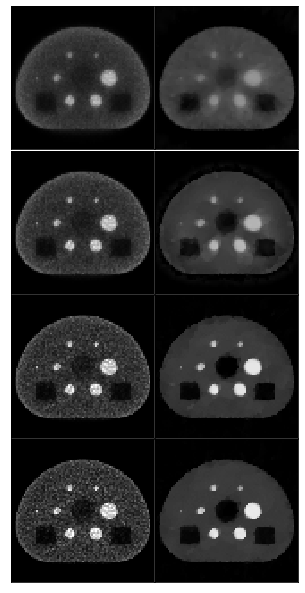

In [88]:
# reproducing Figure 9

im1 = np.load("results/saa_noisy_bothTV_lambda10.npy")/32768.0
im2 = np.load("results/saa_noisy_bothTV_lambda20.npy")/32768.0
im3 = np.load("results/saa_noisy_bothTV_lambda50.npy")/32768.0
im4 = np.load("results/saa_noisy_bothTV_lambda100.npy")/32768.0
mim1 = np.load("results/mlaa_noisy_lambda10.npy")/32768.0
mim2 = np.load("results/mlaa_noisy_lambda20.npy")/32768.0
mim3 = np.load("results/mlaa_noisy_lambda50.npy")/32768.0
mim4 = np.load("results/mlaa_noisy_lambda100.npy")/32768.0

vmm= 0.0
vmx= 1.1
figure(1,figsize=(4,8))
subplot(4,2,1)
imshow(mim1[24:104,24:104],vmin = vmm, vmax = vmx, cmap = cm.gray, interpolation = "nearest")
xticks([])
yticks([])
subplot(4,2,2)
imshow(im1[24:104,24:104],vmin = vmm, vmax = vmx, cmap = cm.gray, interpolation = "nearest")
xticks([])
yticks([])
subplot(4,2,3)
imshow(mim2[24:104,24:104],vmin = vmm, vmax = vmx, cmap = cm.gray, interpolation = "nearest")
xticks([])
yticks([])
subplot(4,2,4)
imshow(im2[24:104,24:104],vmin = vmm, vmax = vmx, cmap = cm.gray, interpolation = "nearest")
xticks([])
yticks([])
subplot(4,2,5)
imshow(mim3[24:104,24:104],vmin = vmm, vmax = vmx, cmap = cm.gray, interpolation = "nearest")
xticks([])
yticks([])
subplot(4,2,6)
imshow(im3[24:104,24:104],vmin = vmm, vmax = vmx, cmap = cm.gray, interpolation = "nearest")
xticks([])
yticks([])
subplot(4,2,7)
imshow(mim4[24:104,24:104],vmin = vmm, vmax = vmx, cmap = cm.gray, interpolation = "nearest")
xticks([])
yticks([])
subplot(4,2,8)
imshow(im4[24:104,24:104],vmin = vmm, vmax = vmx, cmap = cm.gray, interpolation = "nearest")
xticks([])
yticks([])
subplots_adjust(left = 0, bottom = 0,top = 1,right= 1,wspace =0.01,hspace = 0.01)

In [89]:
ntrials = 5

In [91]:
## compute the bias-sd tradeoff for saa-admm with both constraints

# output directory
resultsfile = './results/saa_noisy_trial_bothTV_'

# parameters
tvmuswitch = 1
tvlamswitch = 1
sbmu = 50
sblambda = 0.01
sigmu = sbmu/lproj
taumu = 1.0/(sbmu*lproj)
siglambda = sblambda/ltofproj
taulambda = 1.0/(sblambda*ltofproj)

# initialization
storeiterations=[1,2,3,4,5,6,8,10,12,14,16,18,20,25,30,35,40,45,50,60,70,80,90,100]
nims = len(storeiterations)
imagesum = zeros([nims,nx,ny])
imagesos = zeros([nims,nx,ny])
drmse = []
ilrmse = []
imrmse = []
afrmse = []

# run saa-admm with both TV constraints
for nt in range(ntrials):
   print("trial: ",nt)

   tofdata = tofdata0*1.

   tofdata = np.random.poisson(tofdata).astype("float64") 
   

   worktofsino = 0.*tofsino
   ulambda = 0.*tofsino
   ylambda = 0.*tofsino

   imlambda = testlambda*0.
   wimlambda = testlambda*0.
   ugradlamx = testlambda*0.
   ygradlamx = testlambda*0.
   ugradlamy = testlambda*0.
   ygradlamy = testlambda*0.

   worksino = 0.*sinoatt
   umu = 0.*sinoatt
   ymu = 0.*sinoatt
   ugradmux = testlambda*0.
   ygradmux = testlambda*0.
   ugradmuy = testlambda*0.
   ygradmuy = testlambda*0.

   immu = testmu*0.
   wimmu = testmu*0.



   datarmses = []
   imagelrmses = []
   imagemrmses = []
   attrmses = []
   nim = 0
   for j in range(niter):
# x-update
      TOFprojection(imlambda,worktofsino)
      arg1 = ulambda+siglambda*(worktofsino -ylambda)
      TOFbackProjection(arg1,wimlambda)
      tgx,tgy = gradim(imlambda)
      tgx *= nulam
      tgy *= nulam

      argx = ugradlamx + siglambda*(tgx - ygradlamx)
      argy = ugradlamy + siglambda*(tgy - ygradlamy)
      wgradimlam = mdiv(argx,argy)
      wgradimlam *= nulam*fovmask
      tvlamest  = sqrt(tgx**2 + tgy**2).sum()

# counts constraint block
      nu  = ((imlambda.sum() -ltotalcounts)/taulambda - wimlambda.sum() - wgradimlam)/fovmask.sum()
      imlambda =imlambda -taulambda*(nu*fovmask + wimlambda + wgradimlam)

      TOFprojection(imlambda,worktofsino)
      workgradlamx, workgradlamy = gradim(imlambda)
      workgradlamx *= nulam
      workgradlamy *= nulam

      circularParallelBeamProjection(immu,worksino)
      arg1 = umu +sigmu*( worksino -ymu )
      circularParallelBeamBackProjection(arg1,wimmu)
      tgx,tgy = gradim(immu)
      tgx *= numu
      tgy *= numu
      argx = ugradmux + sigmu*(tgx - ygradmux)
      argy = ugradmuy + sigmu*(tgy - ygradmuy)
      wgradimmu = mdiv(argx,argy)
      wgradimmu *= numu*fovmask

      immu =immu - wimmu*taumu - wgradimmu*taumu
      immu *= mumask
      circularParallelBeamProjection(immu,worksino)
      workgradmux, workgradmuy = gradim(immu)
      workgradmux *= numu
      workgradmuy *= numu

      tvmuest  = sqrt(tgx**2 + tgy**2).sum()

      ylambdat = 1.*ylambda
      ymut = 1.*ymu
    # y-update
      aq = siglambda
      cq = -tofdata
      hessmin = 1.e10
      for k in range(nuv):
         ymuterm = ones([ntof])[:,newaxis,newaxis]*qexp(-ymu)
         bq = ymuterm - ulambda - siglambda*worktofsino #  ylambdat or tofsino for test
         ylambdaold = ylambda*1.
         ylambda = (-bq + sqrt(bq*bq - 4.*aq*cq))/(2.*aq)
         ylambdaold = ylambda*1.

         ymunewt = ymu*0.
         for i in range(newtiter):
            grad = (-qexp(-ymunewt,1)*ylambdaold + tofdata).sum(axis=0) - umu + sigmu*(ymunewt - worksino)
            ymuterm = ylambdaold*qexp(-ymunewt,2)
            hess = ymuterm.sum(axis=0) + sigmu
            hessmin = minimum(hessmin,hess.min())
            ymunewt = ymunewt - grad/hess
         ymuold = ymu*1.
         ymumin = ymunewt.min()
         ymu = ymunewt*1.
         ymu[ymu<0.] = 0.
         ylambdadist = sqrt( ( (ylambda-ylambdaold)**2).sum())
         ymudist = sqrt( ( (ymu-ymuold)**2).sum())

      ptilx= ugradlamx/siglambda + workgradlamx
      ptily= ugradlamy/siglambda + workgradlamy
      ptilmag = sqrt(ptilx**2 + ptily**2)
      tempvex=(ptilmag).flatten()*1.
      if tvlamswitch:
         resvex = euclidean_proj_l1ball(tempvex, s=tvlambda)
      else:
         resvex = tempvex*1.
      resvex.shape = nx,ny
      ptilx[ptilmag>0]=ptilx[ptilmag>0]*resvex[ptilmag>0]/ptilmag[ptilmag>0]
      ptily[ptilmag>0]=ptily[ptilmag>0]*resvex[ptilmag>0]/ptilmag[ptilmag>0]
      ygradlamx = ptilx*1.
      ygradlamy = ptily*1.

      ptilx= ugradmux/sigmu + workgradmux
      ptily= ugradmuy/sigmu + workgradmuy
      ptilmag = sqrt(ptilx**2 + ptily**2)
      tempvex=(ptilmag).flatten()*1.
      if tvmuswitch:
         resvex = euclidean_proj_l1ball(tempvex, s=tvmu)
      else:
         resvex = tempvex*1.
      resvex.shape = nx,ny
      ptilx[ptilmag>0]=ptilx[ptilmag>0]*resvex[ptilmag>0]/ptilmag[ptilmag>0]
      ptily[ptilmag>0]=ptily[ptilmag>0]*resvex[ptilmag>0]/ptilmag[ptilmag>0]
      ygradmux = ptilx*1.
      ygradmuy = ptily*1.
   
# u-update
      TOFprojection(imlambda,worktofsino)
      ulambda = ulambda + siglambda*(worktofsino - ylambda)
      tgx,tgy = gradim(imlambda)
      tgx *= nulam
      tgy *= nulam
      ugradlamx = ugradlamx + siglambda*(tgx - ygradlamx)
      ugradlamy = ugradlamy + siglambda*(tgy - ygradlamy)

      circularParallelBeamProjection(immu,worksino)
      umu = umu +sigmu*(worksino-ymu)
      tgx,tgy = gradim(immu)
      tgx *= numu
      tgy *= numu
      ugradmux = ugradmux + sigmu*(tgx - ygradmux)
      ugradmuy = ugradmuy + sigmu*(tgy - ygradmuy)


      attfactorest = exp(-worksino)
      datarmse = sqrt(( (tofdata-worktofsino*attfactorest)**2. ).sum())/sqrt( (tofdata**2).sum() )
      imagelrmse = sqrt(( (testlambda-imlambda)**2. ).sum())/sqrt( (testlambda**2.).sum() )
      imagemrmse = sqrt(( (testmu-immu)**2. ).sum())/sqrt( (testmu**2.).sum() )
      attdiff = (truess)*(attfactor -  attfactorest)
      attrmse = sqrt(( attdiff**2. ).sum())/sqrt( ((truess*attfactor)**2).sum() )
      datarmses.append(datarmse)
      imagelrmses.append(imagelrmse)
      imagemrmses.append(imagemrmse)
      attrmses.append(attrmse)

      if j+1 in storeiterations:
         print("iter: ",j," ",datarmse," ",imagelrmse," ",imagemrmse," ",attrmse)
         imagesum[nim] += imlambda
         imagesos[nim] += imlambda**2
         nim += 1
   drmse.append(datarmses)
   ilrmse.append(imagelrmses)
   imrmse.append(imagemrmses)
   afrmse.append(attrmses)

for i in range(nims):
   ilmean = imagesum/ntrials
   stdiff =  imagesos - (imagesum**2.)/ntrials
   stdiff[stdiff < 0.] = 0.
   ilstd = sqrt( stdiff/(ntrials-1.) )
save(saaresultsfile+"drmse"+".npy",array(drmse))
save(saaresultsfile+"ilrmse"+".npy",array(ilrmse))
save(saaresultsfile+"imrmse"+".npy",array(imrmse))
save(saaresultsfile+"afrmse"+".npy",array(afrmse))
save(saaresultsfile+"lambdamean"+".npy",ilmean/datafactor)
save(saaresultsfile+"lambdastd"+".npy",ilstd/datafactor)


trial:  0


NameError: name 'qexp' is not defined

In [ ]:
## compute the bias-sd tradeoff for saa-admm with TV constraint on the activity map

# output directory
resultsfile = './results/saa_noisy_trial_lamTV_'

# parameters
tvmuswitch = 0
tvlamswitch = 1
sbmu = 200
sblambda = 0.01
sigmu = sbmu/lproj
taumu = 1.0/(sbmu*lproj)
siglambda = sblambda/ltofproj
taulambda = 1.0/(sblambda*ltofproj)

# initialization
storeiterations=[1,2,3,4,5,6,8,10,12,14,16,18,20,25,30,35,40,45,50,60,70,80,90,100]
nims = len(storeiterations)
imagesum = zeros([nims,nx,ny])
imagesos = zeros([nims,nx,ny])
drmse = []
ilrmse = []
imrmse = []
afrmse = []

# run saa-admm with both TV constraints
for nt in range(ntrials):
   print("trial: ",nt)

   tofdata = tofdata0*1.

   tofdata = random.poisson(tofdata).astype("float64") 
   

   worktofsino = 0.*tofsino
   ulambda = 0.*tofsino
   ylambda = 0.*tofsino

   imlambda = testlambda*0.
   wimlambda = testlambda*0.
   ugradlamx = testlambda*0.
   ygradlamx = testlambda*0.
   ugradlamy = testlambda*0.
   ygradlamy = testlambda*0.

   worksino = 0.*sinoatt
   umu = 0.*sinoatt
   ymu = 0.*sinoatt
   ugradmux = testlambda*0.
   ygradmux = testlambda*0.
   ugradmuy = testlambda*0.
   ygradmuy = testlambda*0.

   immu = testmu*0.
   wimmu = testmu*0.



   datarmses = []
   imagelrmses = []
   imagemrmses = []
   attrmses = []
   nim = 0
   for j in range(niter):
# x-update
      TOFprojection(imlambda,worktofsino)
      arg1 = ulambda+siglambda*(worktofsino -ylambda)
      TOFbackProjection(arg1,wimlambda)
      tgx,tgy = gradim(imlambda)
      tgx *= nulam
      tgy *= nulam

      argx = ugradlamx + siglambda*(tgx - ygradlamx)
      argy = ugradlamy + siglambda*(tgy - ygradlamy)
      wgradimlam = mdiv(argx,argy)
      wgradimlam *= nulam*fovmask
      tvlamest  = sqrt(tgx**2 + tgy**2).sum()

# counts constraint block
      nu  = ((imlambda.sum() -ltotalcounts)/taulambda - wimlambda.sum() - wgradimlam)/fovmask.sum()
      imlambda =imlambda -taulambda*(nu*fovmask + wimlambda + wgradimlam)

      TOFprojection(imlambda,worktofsino)
      workgradlamx, workgradlamy = gradim(imlambda)
      workgradlamx *= nulam
      workgradlamy *= nulam

      circularParallelBeamProjection(immu,worksino)
      arg1 = umu +sigmu*( worksino -ymu )
      circularParallelBeamBackProjection(arg1,wimmu)
      tgx,tgy = gradim(immu)
      tgx *= numu
      tgy *= numu
      argx = ugradmux + sigmu*(tgx - ygradmux)
      argy = ugradmuy + sigmu*(tgy - ygradmuy)
      wgradimmu = mdiv(argx,argy)
      wgradimmu *= numu*fovmask

      immu =immu - wimmu*taumu - wgradimmu*taumu
      immu *= mumask
      circularParallelBeamProjection(immu,worksino)
      workgradmux, workgradmuy = gradim(immu)
      workgradmux *= numu
      workgradmuy *= numu

      tvmuest  = sqrt(tgx**2 + tgy**2).sum()

      ylambdat = 1.*ylambda
      ymut = 1.*ymu
    # y-update
      aq = siglambda
      cq = -tofdata
      hessmin = 1.e10
      for k in range(nuv):
         ymuterm = ones([ntof])[:,newaxis,newaxis]*qexp(-ymu)
         bq = ymuterm - ulambda - siglambda*worktofsino #  ylambdat or tofsino for test
         ylambdaold = ylambda*1.
         ylambda = (-bq + sqrt(bq*bq - 4.*aq*cq))/(2.*aq)
         ylambdaold = ylambda*1.

         ymunewt = ymu*0.
         for i in range(newtiter):
            grad = (-qexp(-ymunewt,1)*ylambdaold + tofdata).sum(axis=0) - umu + sigmu*(ymunewt - worksino)
            ymuterm = ylambdaold*qexp(-ymunewt,2)
            hess = ymuterm.sum(axis=0) + sigmu
            hessmin = minimum(hessmin,hess.min())
            ymunewt = ymunewt - grad/hess
         ymuold = ymu*1.
         ymumin = ymunewt.min()
         ymu = ymunewt*1.
         ymu[ymu<0.] = 0.
         ylambdadist = sqrt( ( (ylambda-ylambdaold)**2).sum())
         ymudist = sqrt( ( (ymu-ymuold)**2).sum())

      ptilx= ugradlamx/siglambda + workgradlamx
      ptily= ugradlamy/siglambda + workgradlamy
      ptilmag = sqrt(ptilx**2 + ptily**2)
      tempvex=(ptilmag).flatten()*1.
      if tvlamswitch:
         resvex = euclidean_proj_l1ball(tempvex, s=tvlambda)
      else:
         resvex = tempvex*1.
      resvex.shape = nx,ny
      ptilx[ptilmag>0]=ptilx[ptilmag>0]*resvex[ptilmag>0]/ptilmag[ptilmag>0]
      ptily[ptilmag>0]=ptily[ptilmag>0]*resvex[ptilmag>0]/ptilmag[ptilmag>0]
      ygradlamx = ptilx*1.
      ygradlamy = ptily*1.

      ptilx= ugradmux/sigmu + workgradmux
      ptily= ugradmuy/sigmu + workgradmuy
      ptilmag = sqrt(ptilx**2 + ptily**2)
      tempvex=(ptilmag).flatten()*1.
      if tvmuswitch:
         resvex = euclidean_proj_l1ball(tempvex, s=tvmu)
      else:
         resvex = tempvex*1.
      resvex.shape = nx,ny
      ptilx[ptilmag>0]=ptilx[ptilmag>0]*resvex[ptilmag>0]/ptilmag[ptilmag>0]
      ptily[ptilmag>0]=ptily[ptilmag>0]*resvex[ptilmag>0]/ptilmag[ptilmag>0]
      ygradmux = ptilx*1.
      ygradmuy = ptily*1.
   
# u-update
      TOFprojection(imlambda,worktofsino)
      ulambda = ulambda + siglambda*(worktofsino - ylambda)
      tgx,tgy = gradim(imlambda)
      tgx *= nulam
      tgy *= nulam
      ugradlamx = ugradlamx + siglambda*(tgx - ygradlamx)
      ugradlamy = ugradlamy + siglambda*(tgy - ygradlamy)

      circularParallelBeamProjection(immu,worksino)
      umu = umu +sigmu*(worksino-ymu)
      tgx,tgy = gradim(immu)
      tgx *= numu
      tgy *= numu
      ugradmux = ugradmux + sigmu*(tgx - ygradmux)
      ugradmuy = ugradmuy + sigmu*(tgy - ygradmuy)


      attfactorest = exp(-worksino)
      datarmse = sqrt(( (tofdata-worktofsino*attfactorest)**2. ).sum())/sqrt( (tofdata**2).sum() )
      imagelrmse = sqrt(( (testlambda-imlambda)**2. ).sum())/sqrt( (testlambda**2.).sum() )
      imagemrmse = sqrt(( (testmu-immu)**2. ).sum())/sqrt( (testmu**2.).sum() )
      attdiff = (truess)*(attfactor -  attfactorest)
      attrmse = sqrt(( attdiff**2. ).sum())/sqrt( ((truess*attfactor)**2).sum() )
      datarmses.append(datarmse)
      imagelrmses.append(imagelrmse)
      imagemrmses.append(imagemrmse)
      attrmses.append(attrmse)

      if j+1 in storeiterations:
         print("iter: ",j," ",datarmse," ",imagelrmse," ",imagemrmse," ",attrmse)
         imagesum[nim] += imlambda
         imagesos[nim] += imlambda**2
         nim += 1
   drmse.append(datarmses)
   ilrmse.append(imagelrmses)
   imrmse.append(imagemrmses)
   afrmse.append(attrmses)

for i in range(nims):
   ilmean = imagesum/ntrials
   stdiff =  imagesos - (imagesum**2.)/ntrials
   stdiff[stdiff < 0.] = 0.
   ilstd = sqrt( stdiff/(ntrials-1.) )
save(saaresultsfile+"drmse"+".npy",array(drmse))
save(saaresultsfile+"ilrmse"+".npy",array(ilrmse))
save(saaresultsfile+"imrmse"+".npy",array(imrmse))
save(saaresultsfile+"afrmse"+".npy",array(afrmse))
save(saaresultsfile+"lambdamean"+".npy",ilmean/datafactor)
save(saaresultsfile+"lambdastd"+".npy",ilstd/datafactor)


In [87]:
## compute the bias-sd tradeoff for saa-admm with TV constraint only on the attenuation map

# output directory
resultsfile = './results/saa_noisy_trial_muTV_'

# parameters
tvmuswitch = 1
tvlamswitch = 0
sbmu = 100
sblambda = 0.01
sigmu = sbmu/lproj
taumu = 1.0/(sbmu*lproj)
siglambda = sblambda/ltofproj
taulambda = 1.0/(sblambda*ltofproj)

# initialization
storeiterations=[1,2,3,4,5,6,8,10,12,14,16,18,20,25,30,35,40,45,50,60,70,80,90,100]
nims = len(storeiterations)
imagesum = zeros([nims,nx,ny])
imagesos = zeros([nims,nx,ny])
drmse = []
ilrmse = []
imrmse = []
afrmse = []

# run saa-admm with both TV constraints
for nt in range(ntrials):
   print("trial: ",nt)

   tofdata = tofdata0*1.

   tofdata = random.poisson(tofdata).astype("float64") 
   

   worktofsino = 0.*tofsino
   ulambda = 0.*tofsino
   ylambda = 0.*tofsino

   imlambda = testlambda*0.
   wimlambda = testlambda*0.
   ugradlamx = testlambda*0.
   ygradlamx = testlambda*0.
   ugradlamy = testlambda*0.
   ygradlamy = testlambda*0.

   worksino = 0.*sinoatt
   umu = 0.*sinoatt
   ymu = 0.*sinoatt
   ugradmux = testlambda*0.
   ygradmux = testlambda*0.
   ugradmuy = testlambda*0.
   ygradmuy = testlambda*0.

   immu = testmu*0.
   wimmu = testmu*0.



   datarmses = []
   imagelrmses = []
   imagemrmses = []
   attrmses = []
   nim = 0
   for j in range(niter):
# x-update
      TOFprojection(imlambda,worktofsino)
      arg1 = ulambda+siglambda*(worktofsino -ylambda)
      TOFbackProjection(arg1,wimlambda)
      tgx,tgy = gradim(imlambda)
      tgx *= nulam
      tgy *= nulam

      argx = ugradlamx + siglambda*(tgx - ygradlamx)
      argy = ugradlamy + siglambda*(tgy - ygradlamy)
      wgradimlam = mdiv(argx,argy)
      wgradimlam *= nulam*fovmask
      tvlamest  = sqrt(tgx**2 + tgy**2).sum()

# counts constraint block
      nu  = ((imlambda.sum() -ltotalcounts)/taulambda - wimlambda.sum() - wgradimlam)/fovmask.sum()
      imlambda =imlambda -taulambda*(nu*fovmask + wimlambda + wgradimlam)

      TOFprojection(imlambda,worktofsino)
      workgradlamx, workgradlamy = gradim(imlambda)
      workgradlamx *= nulam
      workgradlamy *= nulam

      circularParallelBeamProjection(immu,worksino)
      arg1 = umu +sigmu*( worksino -ymu )
      circularParallelBeamBackProjection(arg1,wimmu)
      tgx,tgy = gradim(immu)
      tgx *= numu
      tgy *= numu
      argx = ugradmux + sigmu*(tgx - ygradmux)
      argy = ugradmuy + sigmu*(tgy - ygradmuy)
      wgradimmu = mdiv(argx,argy)
      wgradimmu *= numu*fovmask

      immu =immu - wimmu*taumu - wgradimmu*taumu
      immu *= mumask
      circularParallelBeamProjection(immu,worksino)
      workgradmux, workgradmuy = gradim(immu)
      workgradmux *= numu
      workgradmuy *= numu

      tvmuest  = sqrt(tgx**2 + tgy**2).sum()

      ylambdat = 1.*ylambda
      ymut = 1.*ymu
    # y-update
      aq = siglambda
      cq = -tofdata
      hessmin = 1.e10
      for k in range(nuv):
         ymuterm = ones([ntof])[:,newaxis,newaxis]*qexp(-ymu)
         bq = ymuterm - ulambda - siglambda*worktofsino #  ylambdat or tofsino for test
         ylambdaold = ylambda*1.
         ylambda = (-bq + sqrt(bq*bq - 4.*aq*cq))/(2.*aq)
         ylambdaold = ylambda*1.

         ymunewt = ymu*0.
         for i in range(newtiter):
            grad = (-qexp(-ymunewt,1)*ylambdaold + tofdata).sum(axis=0) - umu + sigmu*(ymunewt - worksino)
            ymuterm = ylambdaold*qexp(-ymunewt,2)
            hess = ymuterm.sum(axis=0) + sigmu
            hessmin = minimum(hessmin,hess.min())
            ymunewt = ymunewt - grad/hess
         ymuold = ymu*1.
         ymumin = ymunewt.min()
         ymu = ymunewt*1.
         ymu[ymu<0.] = 0.
         ylambdadist = sqrt( ( (ylambda-ylambdaold)**2).sum())
         ymudist = sqrt( ( (ymu-ymuold)**2).sum())

      ptilx= ugradlamx/siglambda + workgradlamx
      ptily= ugradlamy/siglambda + workgradlamy
      ptilmag = sqrt(ptilx**2 + ptily**2)
      tempvex=(ptilmag).flatten()*1.
      if tvlamswitch:
         resvex = euclidean_proj_l1ball(tempvex, s=tvlambda)
      else:
         resvex = tempvex*1.
      resvex.shape = nx,ny
      ptilx[ptilmag>0]=ptilx[ptilmag>0]*resvex[ptilmag>0]/ptilmag[ptilmag>0]
      ptily[ptilmag>0]=ptily[ptilmag>0]*resvex[ptilmag>0]/ptilmag[ptilmag>0]
      ygradlamx = ptilx*1.
      ygradlamy = ptily*1.

      ptilx= ugradmux/sigmu + workgradmux
      ptily= ugradmuy/sigmu + workgradmuy
      ptilmag = sqrt(ptilx**2 + ptily**2)
      tempvex=(ptilmag).flatten()*1.
      if tvmuswitch:
         resvex = euclidean_proj_l1ball(tempvex, s=tvmu)
      else:
         resvex = tempvex*1.
      resvex.shape = nx,ny
      ptilx[ptilmag>0]=ptilx[ptilmag>0]*resvex[ptilmag>0]/ptilmag[ptilmag>0]
      ptily[ptilmag>0]=ptily[ptilmag>0]*resvex[ptilmag>0]/ptilmag[ptilmag>0]
      ygradmux = ptilx*1.
      ygradmuy = ptily*1.
   
# u-update
      TOFprojection(imlambda,worktofsino)
      ulambda = ulambda + siglambda*(worktofsino - ylambda)
      tgx,tgy = gradim(imlambda)
      tgx *= nulam
      tgy *= nulam
      ugradlamx = ugradlamx + siglambda*(tgx - ygradlamx)
      ugradlamy = ugradlamy + siglambda*(tgy - ygradlamy)

      circularParallelBeamProjection(immu,worksino)
      umu = umu +sigmu*(worksino-ymu)
      tgx,tgy = gradim(immu)
      tgx *= numu
      tgy *= numu
      ugradmux = ugradmux + sigmu*(tgx - ygradmux)
      ugradmuy = ugradmuy + sigmu*(tgy - ygradmuy)


      attfactorest = exp(-worksino)
      datarmse = sqrt(( (tofdata-worktofsino*attfactorest)**2. ).sum())/sqrt( (tofdata**2).sum() )
      imagelrmse = sqrt(( (testlambda-imlambda)**2. ).sum())/sqrt( (testlambda**2.).sum() )
      imagemrmse = sqrt(( (testmu-immu)**2. ).sum())/sqrt( (testmu**2.).sum() )
      attdiff = (truess)*(attfactor -  attfactorest)
      attrmse = sqrt(( attdiff**2. ).sum())/sqrt( ((truess*attfactor)**2).sum() )
      datarmses.append(datarmse)
      imagelrmses.append(imagelrmse)
      imagemrmses.append(imagemrmse)
      attrmses.append(attrmse)

      if j+1 in storeiterations:
         print("iter: ",j," ",datarmse," ",imagelrmse," ",imagemrmse," ",attrmse)
         imagesum[nim] += imlambda
         imagesos[nim] += imlambda**2
         nim += 1
   drmse.append(datarmses)
   ilrmse.append(imagelrmses)
   imrmse.append(imagemrmses)
   afrmse.append(attrmses)

for i in range(nims):
   ilmean = imagesum/ntrials
   stdiff =  imagesos - (imagesum**2.)/ntrials
   stdiff[stdiff < 0.] = 0.
   ilstd = sqrt( stdiff/(ntrials-1.) )
save(saaresultsfile+"drmse"+".npy",array(drmse))
save(saaresultsfile+"ilrmse"+".npy",array(ilrmse))
save(saaresultsfile+"imrmse"+".npy",array(imrmse))
save(saaresultsfile+"afrmse"+".npy",array(afrmse))
save(saaresultsfile+"lambdamean"+".npy",ilmean/datafactor)
save(saaresultsfile+"lambdastd"+".npy",ilstd/datafactor)


NameError: name 'ntrials' is not defined

In [ ]:
# Reproducing Figure 11
im0 = np.load("UWDRO1_slice40_activity.npy")[::2,::2]*1.
#im0 *= 1.e6/im0.sum()

sim = im0.sum()

storeiterations=array([1,2,3,4,5,6,8,10,12,14,16,18,20,25,30,35,40,45,50,60,70,80,90,100])
subiter = [0,1,4,7,12,18,23]
subiter = [7,12,18,23]

im1 = np.load("saaresults9cm_noisy/lambdamean_TVmu100_TVlam100.npy")
istd1 = np.load("saaresults9cm_noisy/lambdastd_TVmu100_TVlam100.npy")
im2 = np.load("saaresults9cm_noisy/lambdamean_TVmu100.npy")
istd2 = np.load("saaresults9cm_noisy/lambdastd_TVmu100.npy")
im3 = np.load("saaresults9cm_noisy/lambdamean_TVlam100.npy")
istd3 = np.load("saaresults9cm_noisy/lambdastd_TVlam100.npy")


data1 = []
data2 = []
data3 = []
for i in range(len(im1)):
   nmean = sqrt( ((im1[i]-im0)**2).sum() )/sqrt( (im0**2).sum() )
   nstd =  sqrt((istd1[i]**2).sum()) /sqrt( (im0**2).sum() )
   data1.append([nmean,nstd])
   nmean = sqrt( ((im2[i]-im0)**2).sum() )/sqrt( (im0**2).sum() )
   nstd =  sqrt( (istd2[i]**2).sum()) /sqrt( (im0**2).sum() )
   data2.append([nmean,nstd])
   nmean = sqrt( ((im3[i]-im0)**2).sum() )/sqrt( (im0**2).sum() )
   nstd =  sqrt( (istd3[i]**2).sum()) /sqrt( (im0**2).sum() )
   data3.append([nmean,nstd])


data1 = array(data1)
data2 = array(data2)
data3 = array(data3)


figure(1,figsize=(6,5))
plot(data1[7:,0],data1[7:,1],'b-',linewidth=2.0,label="att. and act. TV constraints")
plot(data2[7:,0],data2[7:,1],'g--',linewidth=2.0,label="att. TV constraint only")
plot(data3[7:,0],data3[7:,1],'r:',linewidth=2.0,label="act. TV constraint only")


legend(loc="best",fontsize=14)

subdata1 =data1[subiter]
subdata2 =data2[subiter]
subdata3 =data3[subiter]
tshifts1=array([[0.0,0.005],[-0.02,0.01],[-0.01,0.01],[-0.048,-0.01]])
plot(subdata1[:,0],subdata1[:,1],'bo')
plot(subdata2[:,0],subdata2[:,1],'go')
plot(subdata3[:,0],subdata3[:,1],'rv')

xlabel("normalized bias",fontsize=14)
xticks(fontsize=14)

ylabel("normalized std.",fontsize=14)
yticks(fontsize=14)

piter = storeiterations[subiter].tolist()
print(piter)
for i,txt in enumerate(piter):
   print(i,txt)
   annotate(str(txt),(subdata1[i,0]+tshifts1[i,0],subdata1[i,1]+tshifts1[i,1]),fontsize=14,color="b")


axis([0.0,0.52,0.0,0.5])

subplots_adjust(left= 0.14,bottom= 0.12,top=0.95,right=0.95)
